In [ ]:
import pandas as pd
import numpy  as np
from tqdm import tqdm  #for showing progress bars
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
x1=pd.read_csv('/content/drive/My Drive/task2/train_data.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
y1=pd.read_csv('/content/drive/My Drive/task2/train_label.csv')
y1.columns=["class value"]

In [ ]:
print(y1)

      class value
0             0.0
1             0.0
2             0.0
3             0.0
4             0.0
...           ...
1994          4.0
1995          4.0
1996          4.0
1997          4.0
1998          4.0

[1999 rows x 1 columns]


In [ ]:
num_classes = y1["class value"].nunique()
print(f"Number of unique classes: {num_classes}")
print("shape of our training data", x1.shape)

Number of unique classes: 5
shape of our training data (1999, 36)


In [ ]:
x = torch.tensor(x1.values, dtype=torch.float32)
y = torch.tensor(y1.values.flatten(), dtype=torch.long)

In [ ]:
def get_dataloader(x, y, batch_size=10):
    dataset = TensorDataset(x, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_1, hidden_2, output_size, norm='none'):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_1)  # First hidden layer
        self.fc2 = nn.Linear(hidden_1, hidden_2)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_2, output_size)  # Output layer
        self.tanh = nn.Tanh()
        self.norm = norm

        if norm == 'layer':
            self.ln1 = nn.LayerNorm(hidden_1)
            self.ln2 = nn.LayerNorm(hidden_2)
        elif norm == 'batch':
            self.bn1 = nn.BatchNorm1d(hidden_1)
            self.bn2 = nn.BatchNorm1d(hidden_2)

        # Call weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
    # Initialize weights randomly from a uniform distribution between -1 and 1
      self.fc1.weight.data.uniform_(-1, 1)
      self.fc2.weight.data.uniform_(-1, 1)
      self.fc3.weight.data.uniform_(-1, 1)

      # Initialize biases randomly as well
      self.fc1.bias.data.uniform_(-1, 1)
      self.fc2.bias.data.uniform_(-1, 1)
      self.fc3.bias.data.uniform_(-1, 1)


    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)  # Activation first
        if self.norm == 'layer':
            x = self.ln1(x)  # Apply LayerNorm after activation
        elif self.norm == 'batch':
            x = self.bn1(x)  # Apply BatchNorm after activation

        x = self.fc2(x)
        x = self.tanh(x)  # Activation first
        if self.norm == 'layer':
            x = self.ln2(x)  # Apply LayerNorm after activation
        elif self.norm == 'batch':
            x = self.bn2(x)  # Apply BatchNorm after activation

        x = self.fc3(x)  # No normalization after output layer
        return x


In [ ]:
dataloader = get_dataloader(x, y, 10)
for batchx,batchy in dataloader:
  print(batchx.shape)
  print(batchy.shape)
  break

torch.Size([10, 36])
torch.Size([10])


In [ ]:
def train_and_evaluate(norm_type, learning_rate=0.01, batch_size=200, tol=0.0001, max_epochs=10000):
    torch.manual_seed(42)  # Ensuring reproducibility
    model = NeuralNetwork(x.shape[1], 20, 10, num_classes, norm=norm_type)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    dataloader = get_dataloader(x, y, batch_size)
    losses = []

    for epoch in tqdm(range(max_epochs)):
        total_loss = 0
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)  # model(x) invokes forward
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)

        # Compute relative error and check early stopping condition
        if epoch > 0:
            relative_error = abs(losses[-1] - losses[-2])
            if relative_error < tol:
                print(f"Early stopping at epoch {epoch} (relative error < {tol}")
                break


    return model, losses


Training with none normalization...


  4%|▍         | 433/10000 [00:17<06:21, 25.06it/s]


Early stopping at epoch 433 (relative error < 0.0001
Training with layer normalization...


  3%|▎         | 267/10000 [00:12<07:26, 21.82it/s]


Early stopping at epoch 267 (relative error < 0.0001
Training with batch normalization...


  2%|▏         | 184/10000 [00:07<06:55, 23.62it/s]


Early stopping at epoch 184 (relative error < 0.0001
Final converged loss for none normalization: 0.6938
Final converged loss for layer normalization: 0.8106
Final converged loss for batch normalization: 0.6787


<Figure size 1500x500 with 0 Axes>

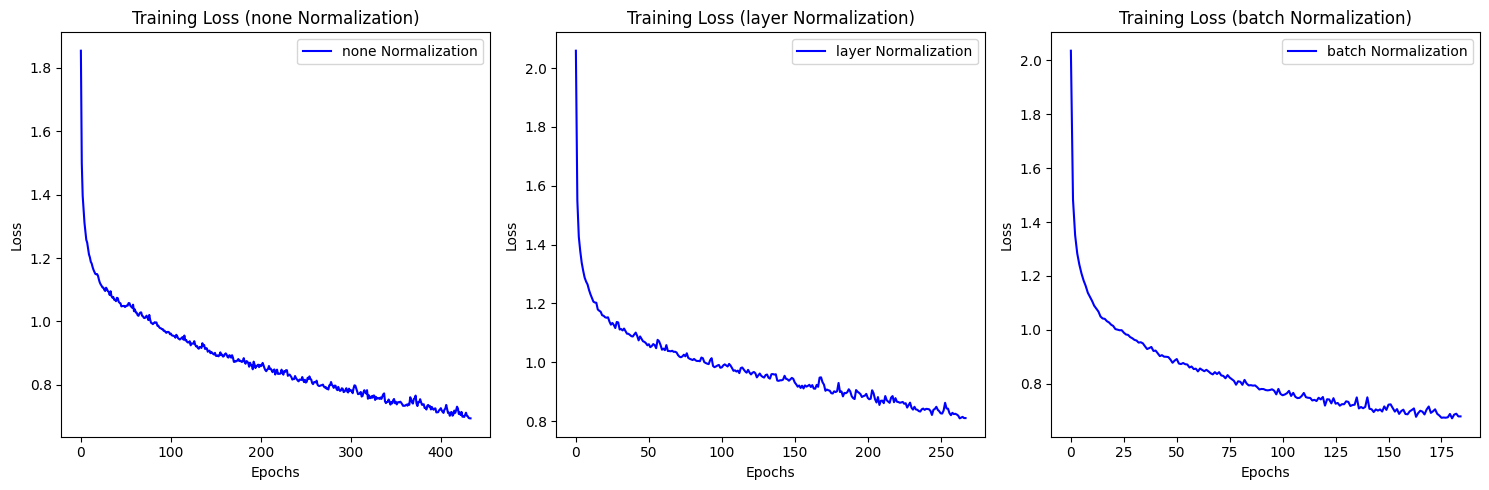

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Increase width for better visualization
norm_types = ['none', 'layer', 'batch']
models = {}
loss_dict = {}

for i, n in enumerate(norm_types):
    print(f"Training with {n} normalization...")
    model, losses = train_and_evaluate(n)
    models[n] = model
    loss_dict[n] = losses  # Store losses for plotting

# Create separate subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, norm in enumerate(norm_types):
    axes[i].plot(range(len(loss_dict[norm])), loss_dict[norm], label=f'{norm} Normalization', color='b')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'Training Loss ({norm} Normalization)')
    axes[i].legend()

    # Print the final loss value
    final_loss = loss_dict[norm][-1]
    print(f"Final converged loss for {norm} normalization: {final_loss:.4f}")

plt.tight_layout()  # Adjust spacing
plt.show()


Confusion Matrix for Training Data (none Normalization)


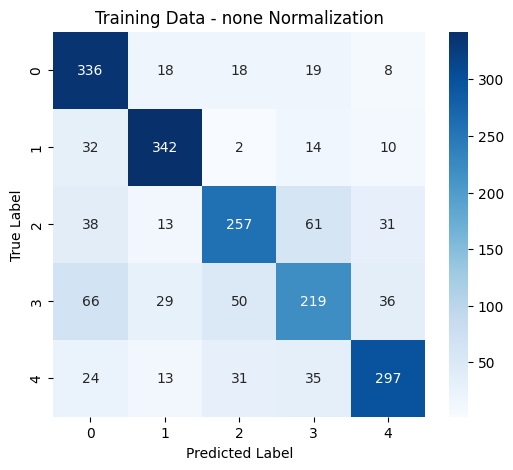

Accuracy: 0.7259
Confusion Matrix for Test Data (none Normalization)


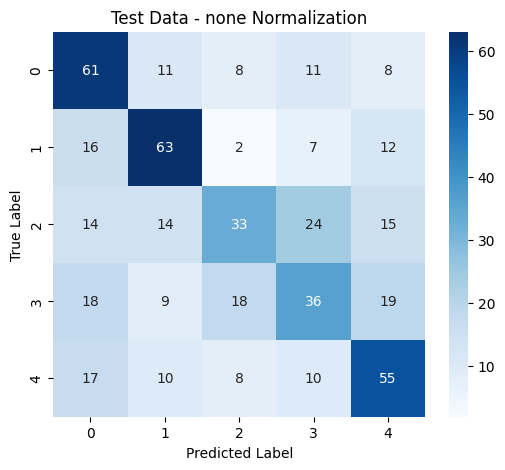

Accuracy: 0.4970
Confusion Matrix for Training Data (layer Normalization)


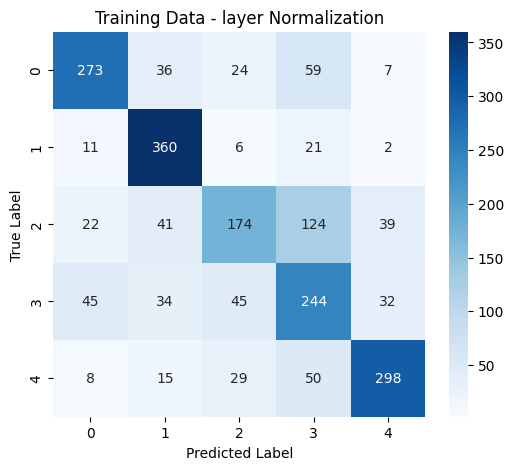

Accuracy: 0.6748
Confusion Matrix for Test Data (layer Normalization)


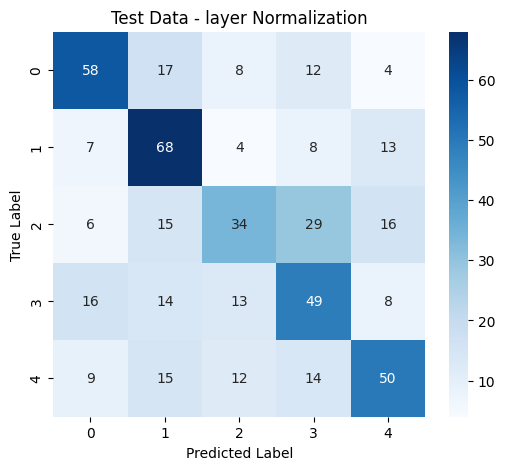

Accuracy: 0.5190
Confusion Matrix for Training Data (batch Normalization)


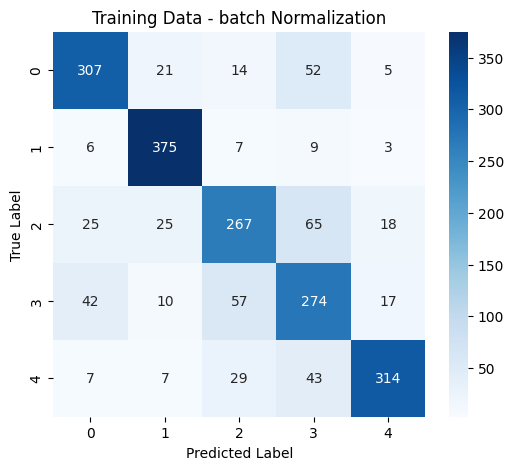

Accuracy: 0.7689
Confusion Matrix for Test Data (batch Normalization)


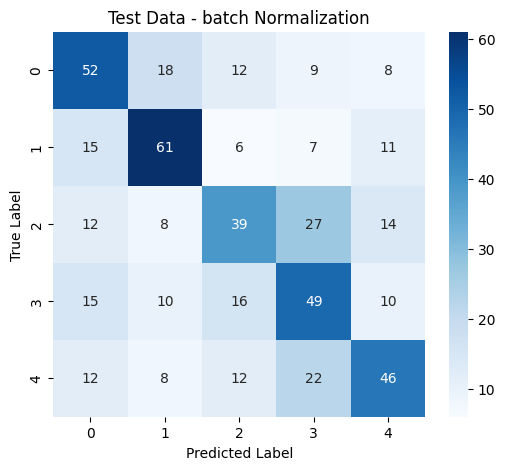

Accuracy: 0.4950


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Load Test Data
x_test = pd.read_csv('/content/drive/My Drive/task2/test_data.csv')
y_test = pd.read_csv('/content/drive/My Drive/task2/test_label.csv')
y_test.columns = ["class value"]

# Convert Test Data to Torch Tensors
x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values.flatten(), dtype=torch.long)

# Ensure num_classes is defined
num_classes = len(y.unique())

def evaluate_and_plot(model, data_x, data_y, title):
    with torch.no_grad():
        preds = model(data_x).argmax(dim=1).cpu().numpy()
        true = data_y.cpu().numpy()
        cm = confusion_matrix(true, preds)

        # Plot Confusion Matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(title)
        plt.show()

        return cm, true, preds

# Function to Calculate Accuracy
def calculate_accuracy(true, preds):
    accuracy = accuracy_score(true, preds)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# Evaluate and plot confusion matrices for training and test data
for norm, model in models.items():
    print(f"Confusion Matrix for Training Data ({norm} Normalization)")
    cm_train, true_train, preds_train = evaluate_and_plot(model, x, y, f'Training Data - {norm} Normalization')
    calculate_accuracy(true_train, preds_train)

    print(f"Confusion Matrix for Test Data ({norm} Normalization)")
    cm_test, true_test, preds_test = evaluate_and_plot(model, x_test, y_test, f'Test Data - {norm} Normalization')
    calculate_accuracy(true_test, preds_test)


In [ ]:
print(x_test.shape)
print(y_test.shape)

torch.Size([499, 36])
torch.Size([499])
